# Frontal Detection Analysis (Jet shifts)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cf_xarray
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

## Read in zonal wind field

In [2]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output
cesm_rcp26_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/" # RCP2.6 output
cesm_rcp85_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP85C5CN/" #RCP8.5 output

In [3]:
# h0.U300 is monthly mean 300mb zonal wind
# remapped from unstructured grid to FV

U300_B20TRC5CN_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h0.U300.200001-200601.regrid_0.23x0.31.nc"
U300_BRCP26C5CN_files = "b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.U300.200601-201512.regrid_0.23x0.31.nc"
U300_BRCP85C5CN_files = "*h0.U300*.nc"

In [4]:
U300_hist_files = [cesm_hist_filepath+U300_B20TRC5CN_files, cesm_rcp26_filepath+U300_BRCP26C5CN_files] # combined hist/rcp26; need explicit filenames (not glob strings) if using a list
U300_rcp_files = cesm_rcp85_filepath+U300_BRCP85C5CN_files

In [5]:
U300_hist_files

['/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/b.e13.B20TRC5CN.ne120_g16.003.cam.h0.U300.200001-200601.regrid_0.23x0.31.nc',
 '/glade/campaign/cgd/ccr/kdagon/dlfront/BRCP26C5CN/b.e13.BRCP26C5CN.ne120_g16.003.cam.h0.U300.200601-201512.regrid_0.23x0.31.nc']

### Preprocessing function

In [6]:
def preprocess(ds):
    # fix CESM time bounds for monthly output
    attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
    time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
    time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
    ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
    ds.time.attrs, ds.time.encoding = attrs, encoding
    # return regional domain
    return ds['U300'].sel(lat=slice(10,77),lon=slice(189,329))

### Read in files with preprocessing function

In [7]:
%%time
U300_hist = xr.open_mfdataset(U300_hist_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess) # unclear if chunking is needed for these monthly (smaller) files

CPU times: user 44.4 ms, sys: 58.2 ms, total: 103 ms
Wall time: 966 ms


In [8]:
U300_hist

<xarray.DataArray 'U300' (time: 192, lat: 285, lon: 448)>
dask.array<concatenate, shape=(192, 285, 448), dtype=float32, chunksize=(119, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 1999-12-16 12:00:00 ... 2015-11-16 00:00:00
Attributes:
    long_name:      Zonal wind at 300 mbar pressure surface
    units:          m/s
    plevo:          300.0
    cell_measures:  area: area

### Subset historical to match number of RCP8.5 years (14)

In [9]:
#U300_hist.sel(time="2000-01") # this works
#U300_hist.sel(time="2014-12") # this works
#U300_hist.sel(time=slice("2000-01", "2014-12")) # this breaks??
U300_hist = U300_hist[1:181] 
U300_hist

<xarray.DataArray 'U300' (time: 180, lat: 285, lon: 448)>
dask.array<getitem, shape=(180, 285, 448), dtype=float32, chunksize=(108, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      Zonal wind at 300 mbar pressure surface
    units:          m/s
    plevo:          300.0
    cell_measures:  area: area

In [10]:
U300_rcp = xr.open_mfdataset(U300_rcp_files, concat_dim='time', combine="nested", chunks={'time':150}, parallel=True, preprocess=preprocess)
U300_rcp

<xarray.DataArray 'U300' (time: 180, lat: 285, lon: 448)>
dask.array<concatenate, shape=(180, 285, 448), dtype=float32, chunksize=(12, 285, 448), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2086-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:      Zonal wind at 300 mbar pressure surface
    units:          m/s
    plevo:          300.0
    cell_measures:  area: area

### Bring in dask resources for plotting
NOTE: dask resources can make this much faster (still intermittently slow and not sure why? high spatial resolution?)\
ALSO NOTE: preprocessing function will not work with dask so need to load dask resources after reading in data

In [3]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 nodes (10 dask workers)
cluster.scale(10)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40163 instead
  warnings.warn(


In [4]:
client

<Client: 'tcp://10.12.206.48:39790' processes=5 threads=5, memory=46.55 GiB>

### Calculate seasonal means and persist for plotting

In [13]:
U300_hist_smean = U300_hist.groupby("time.season").mean(dim='time').persist()
U300_rcp_smean = U300_rcp.groupby("time.season").mean(dim='time').persist()

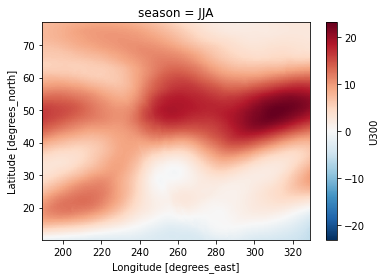

In [14]:
# what do negative values mean? direction?
# I think positive = westerlies (west to east), negative = easterlies (east to west)
U300_hist_smean.sel(season='JJA').plot()

In [15]:
U300_hist_smean.min().values

array(-5.6925883, dtype=float32)

In [16]:
U300_hist_smean.max().values

array(47.952812, dtype=float32)

In [17]:
U300_rcp_smean.min().values

array(-5.4900036, dtype=float32)

In [18]:
U300_rcp_smean.max().values

array(36.028286, dtype=float32)

### Calculate seasonal difference

In [23]:
U300_diff_smean = U300_rcp_smean - U300_hist_smean
U300_diff_smean = U300_diff_smean.persist()

In [24]:
U300_diff_smean.min().values

array(-11.924526, dtype=float32)

In [25]:
U300_diff_smean.max().values

array(6.3175583, dtype=float32)

### Panel plot with seasonal means and differences

why is this so slow??

/glade/scratch/kdagon/ipykernel_75662/676924366.py:40: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
/glade/scratch/kdagon/ipykernel_75662/676924366.py:62: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')


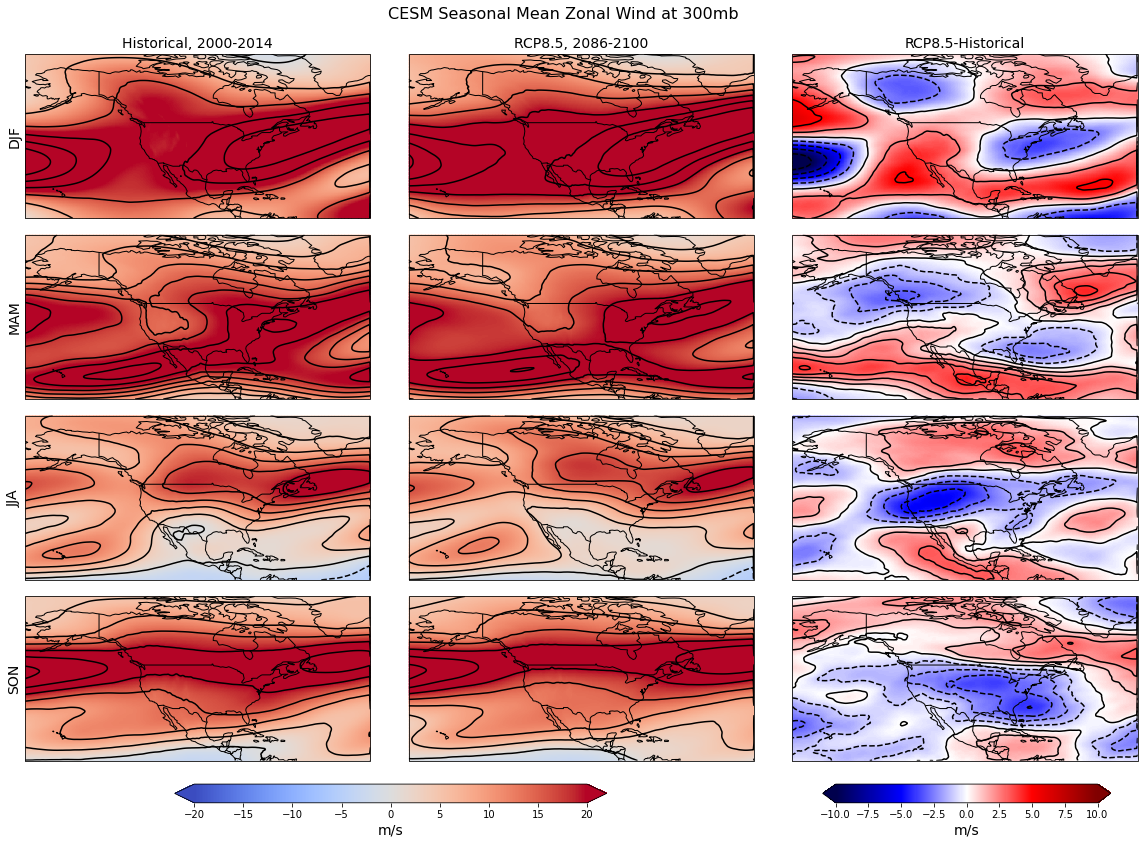

In [30]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=-20
vmax=20
# discrete colormap
#cmap=plt.cm.get_cmap('Greens', 8)
#vmax=4 # for absolute plots

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(U300_hist_smean.sel(season=season), coord=U300_hist_smean.lon)
    lat = U300_hist_smean.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(U300_rcp_smean.sel(season=season), coord=U300_rcp_smean.lon)
    lat = U300_rcp_smean.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('m/s', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-10
vmax2=10

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(U300_diff_smean.sel(season=season), coord=U300_diff_smean.lon)
    lat = U300_diff_smean.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('m/s', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Zonal Wind at 300mb', fontsize=16, y=0.93);

plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_U300_smean.png', bbox_inches='tight')

## Read in surface temperature

In [5]:
# h4.TS is 3hrly instantaneous surface temperature (hist, RCP2.6)
# h5.TS is 3hrly instantaneous surface tempreature (RCP8.5)
# remapped from unstructured grid to FV

TS_files = "*TS*.nc"

### Preprocessing function

In [6]:
def preprocess(ds):
    # return TS data array
    return ds['TS']

### Read in files with preprocessing function

In [8]:
%%time
TS_hist = xr.open_mfdataset(cesm_hist_filepath+TS_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess)
TS_hist

CPU times: user 524 ms, sys: 639 ms, total: 1.16 s
Wall time: 6.05 s


<xarray.DataArray 'TS' (time: 17520, lat: 68, lon: 141)>
dask.array<concatenate, shape=(17520, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

drop the final time index from hist (repeats)

In [11]:
TS_hist = TS_hist[:-1,:,:]
TS_hist

<xarray.DataArray 'TS' (time: 17519, lat: 68, lon: 141)>
dask.array<getitem, shape=(17519, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2005-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

In [9]:
TS_rcp26 = xr.open_mfdataset(cesm_rcp26_filepath+TS_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess)
TS_rcp26

<xarray.DataArray 'TS' (time: 29200, lat: 68, lon: 141)>
dask.array<concatenate, shape=(29200, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

### Combine historical/rcp2.6

In [12]:
TS_present = xr.concat([TS_hist, TS_rcp26], dim='time')
TS_present

<xarray.DataArray 'TS' (time: 46719, lat: 68, lon: 141)>
dask.array<concatenate, shape=(46719, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

### Subset historical to match number of RCP8.5 years (14)

In [13]:
TS_present = TS_present[:43800] 
TS_present

<xarray.DataArray 'TS' (time: 43800, lat: 68, lon: 141)>
dask.array<getitem, shape=(43800, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

In [10]:
TS_rcp85 = xr.open_mfdataset(cesm_rcp85_filepath+TS_files, concat_dim='time', combine="nested", chunks={'time':1500}, parallel=True, preprocess=preprocess)
TS_rcp85

<xarray.DataArray 'TS' (time: 43800, lat: 68, lon: 141)>
dask.array<concatenate, shape=(43800, 68, 141), dtype=float32, chunksize=(1500, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_measures:  area: area

### Calculate seasonal means and persist for plotting

In [14]:
TS_present_smean = TS_present.groupby("time.season").mean(dim='time').persist()
TS_rcp85_smean = TS_rcp85.groupby("time.season").mean(dim='time').persist()

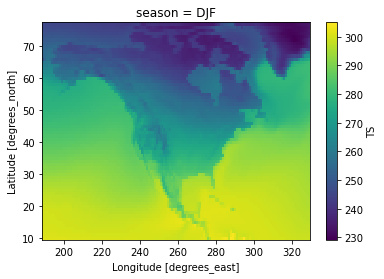

In [15]:
# test plot
TS_present_smean.sel(season='DJF').plot()

In [20]:
KtoC = -273.15
TS_present_smean.min().values + KtoC # convert to degC

-43.99884643554685

In [18]:
TS_present_smean.max().values + KtoC

39.835205078125

In [21]:
TS_rcp85_smean.min().values + KtoC

-40.78739013671873

In [22]:
TS_rcp85_smean.max().values + KtoC

44.61403808593752

### Calculate seasonal difference

In [23]:
TS_diff_smean = TS_rcp85_smean - TS_present_smean
TS_diff_smean = TS_diff_smean.persist()

In [25]:
TS_diff_smean.min().values

array(-4.405609, dtype=float32)

In [26]:
TS_diff_smean.max().values

array(28.308395, dtype=float32)

### Panel plot with seasonal means and differences

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

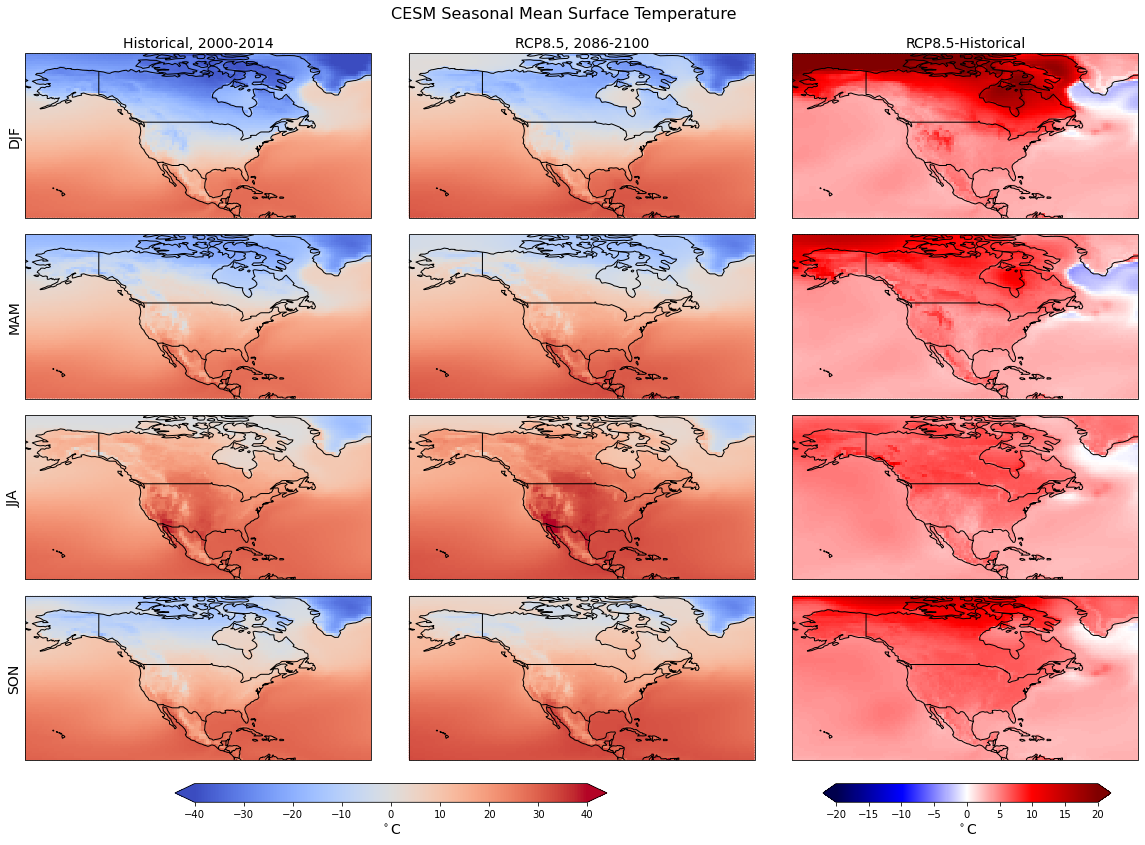

In [27]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=-40
vmax=40

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(TS_present_smean.sel(season=season)+KtoC, coord=TS_present_smean.lon)
    lat = TS_present_smean.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(TS_rcp85_smean.sel(season=season)+KtoC, coord=TS_rcp85_smean.lon)
    lat = TS_rcp85_smean.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('$^\circ$C', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-20
vmax2=20

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(TS_diff_smean.sel(season=season), coord=TS_diff_smean.lon)
    lat = TS_diff_smean.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('$^\circ$C', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Surface Temperature', fontsize=16, y=0.93);

plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_TS_smean.png', bbox_inches='tight')

### Plot CONUS only

In [31]:
TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).min().values + KtoC

-17.055273437499977

In [32]:
TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).max().values + KtoC

39.68520507812502

In [33]:
TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).min().values + KtoC

-8.837988281249977

In [34]:
TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).max().values + KtoC

44.61403808593752

In [35]:
TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).min().values

array(1.2319641, dtype=float32)

In [36]:
TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).max().values

array(9.522614, dtype=float32)

/glade/scratch/kdagon/ipykernel_173251/1733369403.py:37: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
/glade/scratch/kdagon/ipykernel_173251/1733369403.py:59: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')


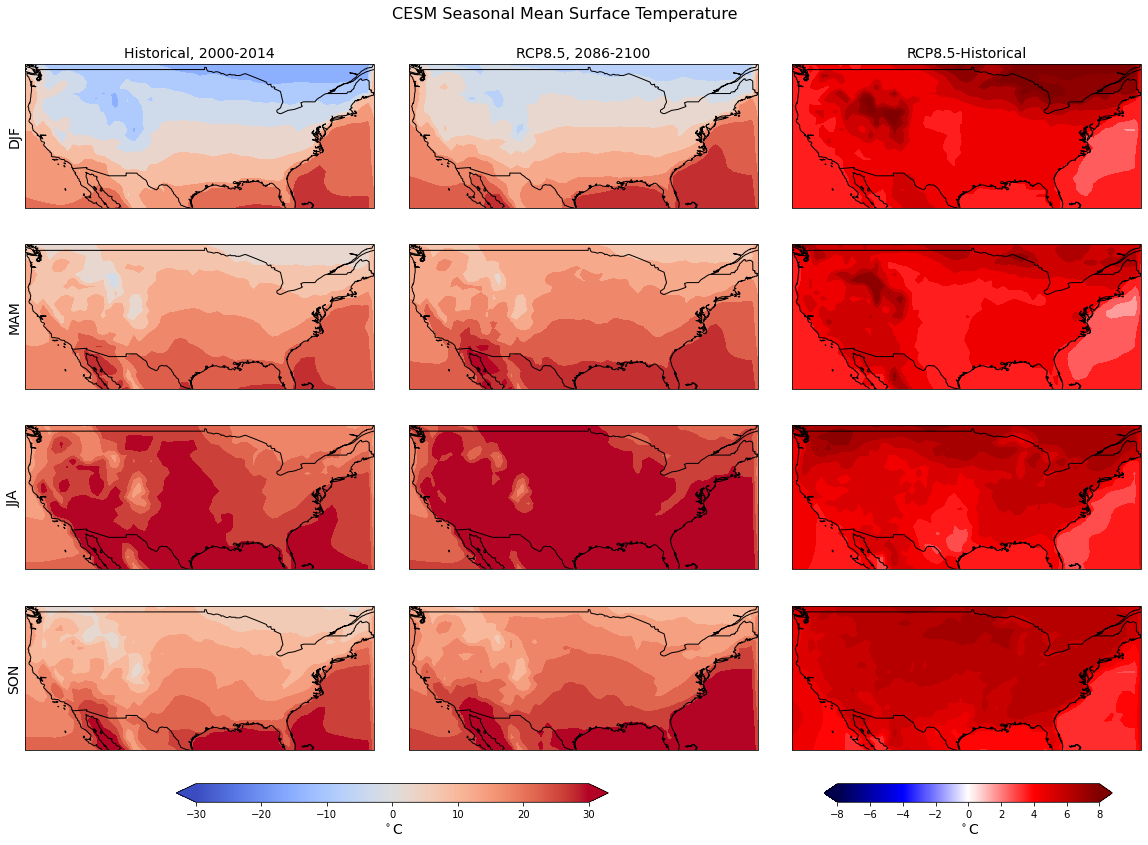

In [43]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('coolwarm')
vmin=-30
vmax=30

for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(TS_present_smean.sel(season=season, lat=slice(26,50), lon=slice(235,292))+KtoC, coord=TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).lon)
    lat = TS_present_smean.sel(lat=slice(26,50), lon=slice(235,292)).lat
    #cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,0].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i, season in enumerate(seastrings):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(TS_rcp85_smean.sel(season=season, lat=slice(26,50), lon=slice(235,292))+KtoC, coord=TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).lon)
    lat = TS_rcp85_smean.sel(lat=slice(26,50), lon=slice(235,292)).lat
    #cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    #axs[i,1].contour(lon, lat, field, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), colors='black')
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.08, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('$^\circ$C', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-8
vmax2=8

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point(TS_diff_smean.sel(season=season, lat=slice(26,50), lon=slice(235,292)), coord=TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).lon)
    lat = TS_diff_smean.sel(lat=slice(26,50), lon=slice(235,292)).lat
    #cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    cf = axs[i,2].contourf(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    #axs[i,2].contour(lon, lat, field, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree(), colors='black')
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('$^\circ$C', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('CESM Seasonal Mean Surface Temperature', fontsize=16, y=0.93);

plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_TS_smean_CONUS_contour.png', bbox_inches='tight')

In [44]:
client.close()
cluster.close()